In [ ]:
# Install necessary libraries
!pip install transformers datasets torch scikit-learn matplotlib seaborn

# Import libraries
import torch
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
from datasets import load_dataset

# Load the IMDB dataset
imdb = load_dataset('imdb')

# Define custom dataset
class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = self.data[index]['text']
        label = self.data[index]['label']
        encoding = self.tokenizer.encode_plus(
            review,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Function to create a balanced subset
def create_balanced_subset(dataset, n=10000):
    pos_samples = [example for example in dataset if example['label'] == 1]
    neg_samples = [example for example in dataset if example['label'] == 0]
    selected_pos = random.sample(pos_samples, n // 2)
    selected_neg = random.sample(neg_samples, n // 2)
    return selected_pos + selected_neg

# Create the balanced dataset and split into train/test
balanced_data = create_balanced_subset(imdb['train'], 10000)
random.shuffle(balanced_data)
train_data = balanced_data[:8000]
test_data = balanced_data[8000:]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Convert data to a pandas DataFrame for a visual check
import pandas as pd
df = pd.DataFrame(train_data + test_data)
print(df.head())

                                                text  label
0  I can always tell when something is going to b...      0
1  I have had the pleasure of reading Martin Torg...      1
2  In the beginning of this film, one of the comm...      1
3  On the face of it a film about women wanting t...      1
4  Despite the feelings of most "Star Wars" fans,...      1


In [ ]:
 # Initialize tokenizer and dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = IMDBDataset(train_data, tokenizer)
test_dataset = IMDBDataset(test_data, tokenizer)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to train and evaluate model with time tracking
def train_and_evaluate(model, optimizer, train_loader, test_loader, criterion, device, epochs=3):
    model = model.to(device)
    total_training_time = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        elapsed_time = time.time() - start_time
        total_training_time += elapsed_time
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Time: {elapsed_time:.2f}s")

    # Evaluation phase
    model.eval()
    all_preds = []
    all_labels = []
    start_time_eval = time.time()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    elapsed_time_eval = time.time() - start_time_eval

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Total Training Time: {total_training_time:.2f}s")
    print(f"Evaluation Time: {elapsed_time_eval:.2f}s")
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training with No Mixed Precision:


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.3808 | Time: 219.54s
Epoch 2/3 | Loss: 0.2113 | Time: 210.64s
Epoch 3/3 | Loss: 0.0980 | Time: 210.70s
Total Training Time: 640.89s
Evaluation Time: 22.79s
Accuracy: 0.8680, Precision: 0.9012, Recall: 0.8227, F1: 0.8602


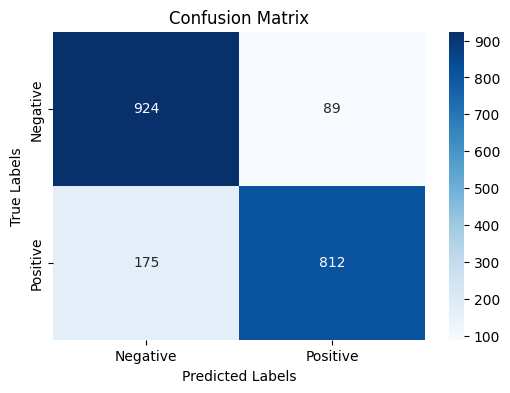

In [ ]:
 #No Mixed Precision Model
print("Training with No Mixed Precision:")
model_fp32 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer_fp32 = optim.Adam(model_fp32.parameters(), lr=2e-5)
criterion_fp32 = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_evaluate(model_fp32, optimizer_fp32, train_loader, test_loader, criterion_fp32, device)


In [ ]:
# Automatic Mixed Precision Model
print("\nTraining with Automatic Mixed Precision:")
model_amp = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer_amp = optim.Adam(model_amp.parameters(), lr=2e-5)
scaler = torch.cuda.amp.GradScaler()


Training with Automatic Mixed Precision:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-ff784b302a28>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


<ipython-input-7-895937eef9d2>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/3 | Loss: 0.3754 | Time: 99.22s
Epoch 2/3 | Loss: 0.2042 | Time: 99.14s
Epoch 3/3 | Loss: 0.0958 | Time: 98.93s


<ipython-input-7-895937eef9d2>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Total Training Time: 297.29s
Evaluation Time: 15.38s
Accuracy: 0.8610, Precision: 0.8926, Recall: 0.8166, F1: 0.8529


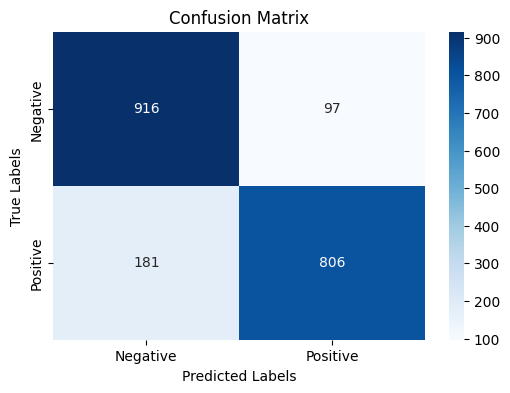

In [ ]:
def train_and_evaluate_amp(model, optimizer, train_loader, test_loader, criterion, device, scaler, epochs=3):
    model = model.to(device)
    total_training_time = 0

    # Training loop with AMP
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        elapsed_time = time.time() - start_time
        total_training_time += elapsed_time
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Time: {elapsed_time:.2f}s")

    # Evaluation phase
    model.eval()
    all_preds = []
    all_labels = []
    start_time_eval = time.time()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    elapsed_time_eval = time.time() - start_time_eval

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Total Training Time: {total_training_time:.2f}s")
    print(f"Evaluation Time: {elapsed_time_eval:.2f}s")
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

train_and_evaluate_amp(model_amp, optimizer_amp, train_loader, test_loader, criterion_fp32, device, scaler)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.3835 | Time: 214.18s
Epoch 2/3 | Loss: 0.2169 | Time: 214.66s
Epoch 3/3 | Loss: 0.1094 | Time: 214.65s
Total Training Time: 643.49s
Evaluation Time: 22.52s
Accuracy: 0.8655, Precision: 0.8517, Recall: 0.8802, F1: 0.8657


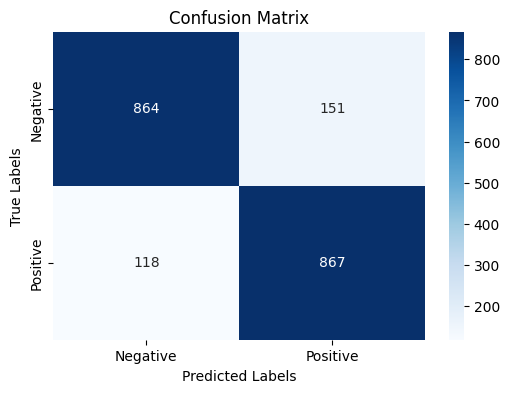

In [ ]:
import torch
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function for Manual Mixed Precision Training and Evaluation with manual control over precision
def train_and_evaluate_manual_fp_control(model, optimizer, train_loader, test_loader, criterion, device, epochs=3):
    model = model.to(device)
    total_training_time = 0

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            # Load data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Do NOT cast input_ids (because embedding layers need Long tensor)
            # Manually cast only certain operations to FP16
            attention_mask = attention_mask.half()  # Manually cast attention mask to FP16

            # Keep certain operations in FP32 (like loss calculation)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits.float(), labels)  # FP32 for loss calculation

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        elapsed_time = time.time() - start_time
        total_training_time += elapsed_time
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Time: {elapsed_time:.2f}s")

    # Evaluation Phase
    model.eval()
    all_preds = []
    all_labels = []
    start_time_eval = time.time()

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Again, do NOT cast input_ids for inference
            attention_mask = attention_mask.half()  # Manually cast to FP16 for attention mask

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    elapsed_time_eval = time.time() - start_time_eval

    # Calculate Metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Total Training Time: {total_training_time:.2f}s")
    print(f"Evaluation Time: {elapsed_time_eval:.2f}s")
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Now calling the function to run manual mixed precision training

# Define model, optimizer, criterion (loss function), and other required variables
model_manual = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer_manual = torch.optim.Adam(model_manual.parameters(), lr=2e-5)
criterion_fp32 = torch.nn.CrossEntropyLoss()

# Example train_loader and test_loader with IMDBDataset

# And device is set to 'cuda' or 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calling the function for manual mixed precision training
train_and_evaluate_manual_fp_control(model_manual, optimizer_manual, train_loader, test_loader, criterion_fp32, device, epochs=3)
